# MPA-MLF: Final project

Made by Dmitrii Semenov, Josef Pecka

Step 1: Import libraries

In [1]:
# Import general libraries
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Import main functions for ML
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split


# Import Tuner
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

# Import confusion matrix fucntion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set plot font 
font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

Step 2: Load input files

In [2]:
# Set dataset paths
dataset_dir = ""
train_dir = os.path.join(dataset_dir, "Train")
test_dir = os.path.join(dataset_dir, "Test")
labels_path = os.path.join(dataset_dir, "label_train.csv")
test_format_path = os.path.join(dataset_dir, "test_format.csv")

# Load labels file
labels_df = pd.read_csv(labels_path)

# Prepare containers
X = []
y = []

# Loop through each file ID
for _, row in labels_df.iterrows():
    file_name = f"{row['ID']}.npy"
    file_path = os.path.join(train_dir, file_name)
    try:
        sample = np.load(file_path)
        X.append(sample)
        y.append(row['target'])
    except Exception as e:
        print(f"[Error] Could not load {file_name}: {e}")

# Convert to NumPy arrays
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

print(f"[INFO] Loaded {X.shape[0]} samples of shape {X.shape[1:]}")
print(f"[INFO] Max value of X data {np.max(X)}")
print(f"[INFO] Min value of X data {np.min(X)}")


[INFO] Loaded 1491 samples of shape (72, 48)
[INFO] Max value of X data 76.52984619140625
[INFO] Min value of X data -66.49512481689453


Step 3: Data preprocessing

In [3]:
# Z-score normalization
X = X.astype("float32")
X_mean = X.mean()
X_std = X.std()
X = (X - X_mean) / X_std

print(f"[INFO] Mean value of data after Z-score normalizations: {np.mean(X)}")

# Reshape for CNN input
X = X.reshape((-1, 72, 48, 1))

# One-hot encode labels
NUM_CLASSES = 3
y = to_categorical(y, NUM_CLASSES)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y,
    test_size=0.2,
    stratify=y.argmax(axis=1),
    random_state=42
)

# Print result
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}, y_val shape: {y_val.shape}")

[INFO] Mean value of data after Z-score normalizations: -4.2031363278738354e-08
X_train shape: (1192, 72, 48, 1), X_val shape: (299, 72, 48, 1)
y_train shape: (1192, 3), y_val shape: (299, 3)


Visualize class distribution in training and validation sets

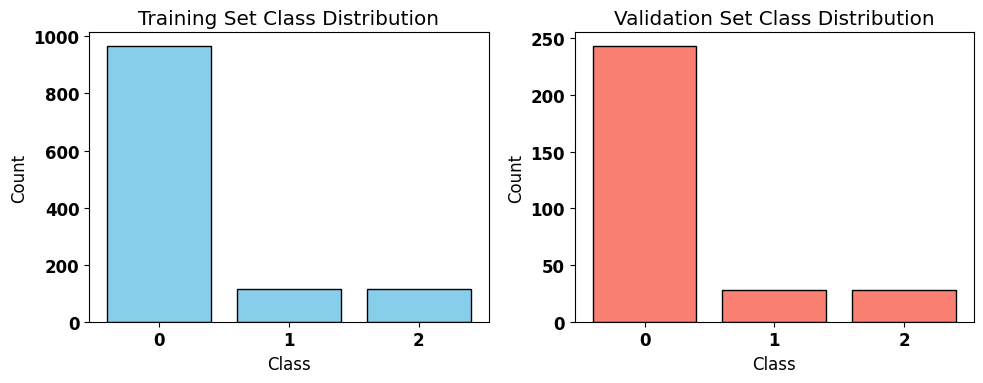

In [4]:
# Convert one-hot labels back to class indices
y_train_labels = y_train.argmax(axis=1)
y_val_labels = y_val.argmax(axis=1)

# Plot
plt.figure(figsize=(10, 4))

# Training set
plt.subplot(1, 2, 1)
plt.hist(y_train_labels, bins=np.arange(NUM_CLASSES + 1) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')
plt.xticks(range(NUM_CLASSES))
plt.title("Training Set Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

# Validation set
plt.subplot(1, 2, 2)
plt.hist(y_val_labels, bins=np.arange(NUM_CLASSES + 1) - 0.5, rwidth=0.8, color='salmon', edgecolor='black')
plt.xticks(range(NUM_CLASSES))
plt.title("Validation Set Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

Step 4: CNN model definition + Keras Tuner

In [5]:
def build_model(hp):
    model = Sequential()
    
    # Input layer
    model.add(Conv2D(
        filters=hp.Choice("filters_1", [32, 64, 128, 256, 512]),
        kernel_size=hp.Choice("kernel_size_1", [3, 5]),
        activation='relu',
        input_shape=(72, 48, 1)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    
    # Optional Conv layer 2
    if hp.Boolean("add_conv_2"):
        model.add(Conv2D(
            filters=hp.Choice("filters_2", [32, 64, 128, 256, 512]),
            kernel_size=hp.Choice("kernel_size_2", [3, 5]),
            activation='relu'
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2))

    # Optional Conv layer 3
    if hp.Boolean("add_conv_3"):
        model.add(Conv2D(
            filters=hp.Choice("filters_3", [32, 64, 128, 256, 512]),
            kernel_size=hp.Choice("kernel_size_3", [3, 5]),
            activation='relu'
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    
    model.add(Dense(
        units=hp.Int("dense_units", min_value=64, max_value=512, step=64),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float("dropout", 0.2, 0.5, step=0.1)))

    model.add(Dense(3, activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling='log')),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

Step 5: Run Keras Tuner to Find the Best Hyperparameters


In [6]:
# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,            # You can increase this for better results
    executions_per_trial=1,    # Runs per model setting
    directory='tuner_results',
    project_name='cnn_tuning'
)

# Tuner summary
tuner.search_space_summary()

# Run the tuner
tuner.search(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True)
    ],
    verbose=2
)

# Show the best model found
tuner.results_summary()

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 20 Complete [00h 00m 53s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 18m 58s
Results summary
Results in tuner_results/cnn_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
filters_1: 32
kernel_size_1: 5
add_conv_2: False
add_conv_3: False
dense_units: 384
dropout: 0.2
learning_rate: 0.00032888370410083404
Score: 1.0

Trial 19 summary
Hyperparameters:
filters_1: 128
kernel_size_1: 3
add_conv_2: False
add_conv_3: False
dense_units: 128
dropout: 0.4
learning_rate: 0.00014904831575780468
filters_2: 128
kernel_size_2: 3
filters_3: 512
kernel_size_3: 5
Score: 1.0

Trial 11 summary
Hyperparameters:
filters_1: 512
kernel_size_1: 5
add_conv_2: False
add_conv_3: False
dense_units: 384
dropout: 0.4
learning_rate: 0.0007245767269284997
filters_2: 128
kernel_size_2: 5
filters_3: 64
kernel_size_3: 3
Score: 0.9933110475540161

Trial 01 summary
Hyperparameters:
filters_1: 512
kernel_size_1: 3
add_conv_2:

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Step 6: Final training of the best model and evaluation

In [7]:
# Retrain the best model
history = best_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True)
    ],
    verbose=2
)

Epoch 1/20
38/38 - 2s - 45ms/step - accuracy: 0.9824 - loss: 0.0610 - val_accuracy: 0.9866 - val_loss: 0.0527
Epoch 2/20
38/38 - 1s - 29ms/step - accuracy: 0.9966 - loss: 0.0076 - val_accuracy: 0.9866 - val_loss: 0.0248
Epoch 3/20
38/38 - 1s - 29ms/step - accuracy: 0.9958 - loss: 0.0163 - val_accuracy: 0.9599 - val_loss: 0.0976
Epoch 4/20
38/38 - 1s - 29ms/step - accuracy: 0.9891 - loss: 0.0383 - val_accuracy: 0.9933 - val_loss: 0.0436
Epoch 5/20
38/38 - 1s - 29ms/step - accuracy: 0.9933 - loss: 0.0293 - val_accuracy: 0.9900 - val_loss: 0.0376


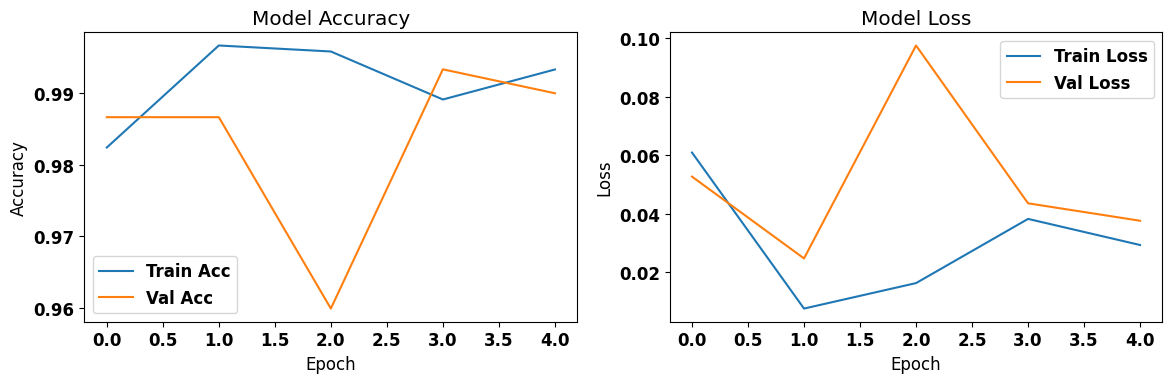

In [8]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Step 7: Predictions on test set

In [9]:
# Load test filenames
test_file_names = sorted([f for f in os.listdir(test_dir) if f.endswith(".npy")])

# Load and normalize test data
X_test = []

for fname in test_file_names:
    path = os.path.join(test_dir, fname)
    sample = np.load(path)
    X_test.append(sample)

X_test = np.array(X_test).astype("float32")

# Apply Z-score normalization using train mean/std
X_test = (X_test - X_mean) / X_std

# Reshape for CNN input
X_test = X_test.reshape((-1, 72, 48, 1))

print(f"Loaded {X_test.shape[0]} test samples")

Loaded 120 test samples


In [10]:
# Predict class probabilities
y_test_probs = best_model.predict(X_test)

# Convert to class labels (0, 1, 2)
y_test_pred = y_test_probs.argmax(axis=1)

# Preview
print("Predicted labels:", y_test_pred[:10])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted labels: [1 0 1 0 0 2 1 2 2 1]


Step 8: Save Kaggle Submission File

In [11]:
# Load test_format.csv
test_format_path = os.path.join(dataset_dir, "test_format.csv")
submission_df = pd.read_csv(test_format_path)

# Add predicted labels
submission_df["target"] = y_test_pred

# Save to CSV for Kaggle
submission_file = "submission.csv"
submission_df.to_csv(submission_file, index=False)

print(f"[INFO] Submission file saved: {submission_file}")
print(submission_df.head())

[INFO] Submission file saved: submission.csv
   ID  target
0   0       1
1   1       0
2   2       1
3   3       0
4   4       0
